In [1]:
import os
import sys
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines

%matplotlib inline

In [2]:
ROOT_DIR = os.path.abspath("../../")
print (ROOT_DIR)
sys.path.append(ROOT_DIR)
from mrcnn import utils
from mrcnn import visualize

from mrcnn import model as modellib

log = modellib.log

from falling_things import things







/home_local/kala_ro/Mask_RCNN


Using TensorFlow backend.


In [3]:
config = things.f_things_config()
main_dir = os.path.abspath("../../../")
data_dir = os.path.join(main_dir,'fat')
print(data_dir)


/home_local/kala_ro/fat


In [4]:
dataset = things.f_things_dataset()
dataset.load_fthings(data_dir,"val")
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format((dataset.num_classes)))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))


Image Count: 6000
Class Count: 2
  0. BG                                                
  1. object                                            


In [ ]:
image_ids = np.random.choice(dataset.image_ids, 5)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image,mask,class_ids, dataset.class_names,limit =1)
    
    
    

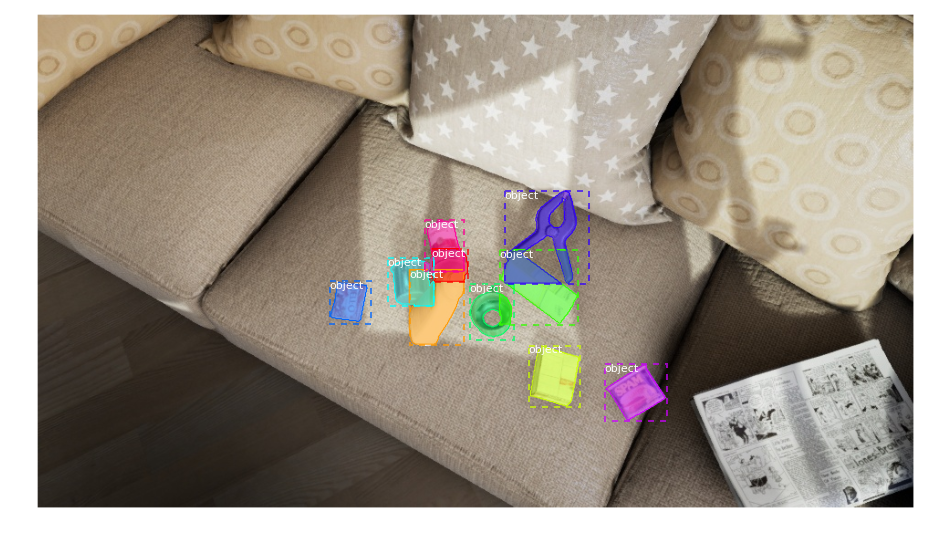

In [5]:
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)


bbox_from_labels = utils.extract_bboxes_from_labels(image_id,dataset)





visualize.display_instances(image, bbox_from_labels, mask, class_ids, dataset.class_names, show_bbox=True,show_mask =True)



In [ ]:
def extract_bboxes_from_labels(image_id, dataset, resize = False):
    """Compute bounding boxes from masks.
    mask: [height, width, num_instances]. Mask pixels are either 1 or 0.

    Returns: bbox array [num_instances, (y1, x1, y2, x2)].
    
    """
    info = dataset.image_info[image_id]
    
    boxes = np.zeros([len(info['b_boxes']), 4], dtype=np.int32)
    for n,i in enumerate(info['b_boxes']):
      
        # Bounding box.
        horizontal_indicies = np.array([i['top_left'][1],i['bottom_right'][1]])
        vertical_indicies = np.array([i['bottom_right'][0],i['top_left'][0]])
      
        x1, x2 = horizontal_indicies[[0, -1]]
        y1, y2 = vertical_indicies[[0, -1]]
       
        
        # x2 and y2 should not be part of the box. Increment by 1.
        x2 += 1
        y2 += 1
        if resize:
            y1, y2 = y1+210 , y2+210
        boxes[n] = np.array([y1, x1, y2, x2])
    return boxes.astype(np.int32)


In [ ]:
import os
import sys
import random
import itertools
import colorsys

import numpy as np
from skimage.measure import find_contours
import matplotlib.pyplot as plt
from matplotlib import patches,  lines
from matplotlib.patches import Polygon
import IPython.display

def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

def display_instances(image, boxes,masks, class_ids, class_names,
                      scores=None, title="",
                      figsize=(16,16), ax=None,
                      show_mask=False, show_bbox=True,
                      colors=None, captions=None):
    
    '''boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [height, width, num_instances]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    title: (optional) Figure title
    show_mask, show_bbox: To show masks and bounding boxes or not
    figsize: (optional) the size of the image
    colors: (optional) An array or colors to use with each object
    captions: (optional) A list of strings to use as captions for each object'''
    
    # Number of instances
    
    N = masks.shape[-1]
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]
   
    # If no axis is passed, create one and automatically call show()
    auto_show = False
    if not ax:
        _, ax = plt.subplots(1,figsize = figsize)
        auto_show = True
    
    # Generate random colors
    colors = colors or random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)
    
    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]

        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        y1, x1, y2, x2 = boxes[i]
        '''if y1 < 0:
            y1 = 0
        if y2 > 540:
            y2 = 540'''
        
        if show_bbox:
            p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                                alpha=0.7, linestyle="dashed",
                                edgecolor=color, facecolor='none')
            ax.add_patch(p)

        # Label
        if not captions:
            class_id = class_ids[i]
            score = scores[i] if scores is not None else None
            label = class_names[class_id]
            x = random.randint(x1, (x1 + x2) // 2)
            caption = "{} {:.3f}".format(label, score) if score else label
        else:
            caption = captions[i]
        ax.text(x1, y1 + 8, caption,
                color='w', size=11, backgroundcolor="none")

         # Mask
        mask = masks[:, :, i]
        if show_mask:
            masked_image = apply_mask(masked_image, mask, color)

        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        padded_mask = np.zeros(
            (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
            # Subtract the padding and flip (y, x) to (x, y)
            verts = np.fliplr(verts) - 1
            p = Polygon(verts, facecolor="none", edgecolor=color)
            ax.add_patch(p)
    ax.imshow(masked_image.astype(np.uint8), origin = 'lower')
    if auto_show:
        plt.show()

In [ ]:
image_id = np.random.choice(dataset.image_ids,1)[0]
image = dataset.load_image(image_id)
mask,class_ids =dataset.load_mask(image_id)
original_shape = image.shape

image,window,scale, padding,_ = utils.resize_image(image,
                                                 min_dim = config.IMAGE_MIN_DIM,
                                                 max_dim = config.IMAGE_MAX_DIM
                                                 )
mask = utils.resize_mask(mask,scale,padding)
bbox = utils.extract_bboxes_from_labels(image_id,dataset,resize = True)
log = modellib.log

print("image_id: ", image_id, dataset.image_reference(image_id))
print("Original shape: ", original_shape)
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)

visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names,show_mask =False)


In [ ]:

image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(dataset, config, image_id, use_mini_mask= False)

log("image", image)
log("image_meta", image_meta)
log("class_ids", class_ids)
log("bbox", bbox)
log("mask", mask)

visualize.display_images([image] + [mask[:,:,0]])



In [ ]:
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

In [ ]:
image, image_meta, class_ids, bbox ,mask = modellib.load_image_gt(dataset, config, image_id,
                                                                  use_mini_mask= True)
log("mask", mask)
visualize.display_images([image]+ [mask[:,:,0]])


In [ ]:
backbone_shapes = modellib.compute_backbone_shapes(config, image.shape)
anchors = utils.generate_pyramid_anchors(config.RPN_ANCHOR_SCALES,
                                        config.RPN_ANCHOR_RATIOS,
                                        backbone_shapes,
                                        config.BACKBONE_STRIDES,
                                        config.RPN_ANCHOR_STRIDE)

num_levels = len(backbone_shapes)
anchors_per_cell = len(config.RPN_ANCHOR_RATIOS)
print("Count: ", anchors.shape[0])
print("Scales: ", config.RPN_ANCHOR_SCALES)
print("Ratios: ", config.RPN_ANCHOR_RATIOS)
print("Anchors per cell: ", anchors_per_cell)
print("Levels: ", num_levels)
anchors_per_level = []

for l in range(num_levels):
    num_cells = backbone_shapes[l][0] * backbone_shapes[l][1]
    anchors_per_level.append(anchors_per_cell * num_cells // config.RPN_ANCHOR_STRIDE**2)
    print("Anchors in Level {}:{}".format(l, anchors_per_level[l]))
          
          
fig, ax = plt.subplots(1, figsize = (10,10))
ax.imshow(image)
levels = len(backbone_shapes)    

for level in range(levels):
          colors = visualize.random_colors(levels)
          level_start =  sum(anchors_per_level[:level])
          level_anchors = anchors[level_start: level_start+anchors_per_level[level]]
          print("Level {}. Anchors: {:6} Feature map shape: {}".format(level,
                                                                       level_anchors.shape[0],backbone_shapes[level]))
          center_cell = backbone_shapes[level] // 2
          center_cell_index = (center_cell[0] * backbone_shapes[level][1]+ center_cell[1])
          level_center = center_cell_index * anchors_per_cell
          center_anchor = anchors_per_cell * ((center_cell[0] * backbone_shapes[level][1] / config.RPN_ANCHOR_STRIDE**2) \
        + center_cell[1] / config.RPN_ANCHOR_STRIDE)
          level_center = int(center_anchor)
          
          
          for i ,rect in enumerate(level_anchors[level_center:level_center+anchors_per_cell]):
              y1, x1, y2, x2 = rect
              p = patches.Rectangle((x1,y1), x2-x1, y2-y1, linewidth=2, facecolor= 'none',
                                   edgecolor = (i+1)*np.array(colors[level]) / anchors_per_cell)
              ax.add_patch(p)
                                    

In [ ]:
random_rois = 2000
g = modellib.data_generator(dataset,config,shuffle=True, random_rois=random_rois, batch_size=4,detection_targets=True)

for i in range(1000):
    print(i)
    _,_ = next(g)

In [ ]:

if random_rois:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_class_ids, gt_boxes, gt_masks, rpn_rois, rois], \
    [mrcnn_class_ids, mrcnn_bbox, mrcnn_mask] = next(g)
    
    log("rois", rois)
    log("mrcnn_class_ids", mrcnn_class_ids)
    log("mrcnn_bbox", mrcnn_bbox)
    log("mrcnn_mask", mrcnn_mask)
else:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_boxes, gt_masks], _ = next(g)
    
log("gt_class_ids", gt_class_ids)
log("gt_boxes", gt_boxes)
log("gt_masks", gt_masks)
log("rpn_match", rpn_match, )
log("rpn_bbox", rpn_bbox)
image_id = image_meta[0][0]
print("image_id: ", image_id, dataset.image_reference(image_id))

# Remove the last dim in mrcnn_class_ids. It's only added
# to satisfy Keras restriction on target shape.
mrcnn_class_ids = mrcnn_class_ids[:,:,0]

In [ ]:
b = 0

# Restore original image (reverse normalization)
sample_image = modellib.unmold_image(normalized_images[b], config)

# Compute anchor shifts.
indices = np.where(rpn_match[b] == 1)[0]
refined_anchors = utils.apply_box_deltas(anchors[indices], rpn_bbox[b, :len(indices)] * config.RPN_BBOX_STD_DEV)
log("anchors", anchors)
log("refined_anchors", refined_anchors)

# Get list of positive anchors
positive_anchor_ids = np.where(rpn_match[b] == 1)[0]
print("Positive anchors: {}".format(len(positive_anchor_ids)))
negative_anchor_ids = np.where(rpn_match[b] == -1)[0]
print("Negative anchors: {}".format(len(negative_anchor_ids)))
neutral_anchor_ids = np.where(rpn_match[b] == 0)[0]
print("Neutral anchors: {}".format(len(neutral_anchor_ids)))

# ROI breakdown by class
for c, n in zip(dataset.class_names, np.bincount(mrcnn_class_ids[b].flatten())):
    if n:
        print("{:23}: {}".format(c[:20], n))

# Show positive anchors
fig, ax = plt.subplots(1, figsize=(16, 16))
visualize.draw_boxes(sample_image, boxes=anchors[positive_anchor_ids], 
                     refined_boxes=refined_anchors, ax=ax)

In [ ]:
visualize.draw_boxes(sample_image, boxes=anchors[negative_anchor_ids])

In [ ]:
visualize.draw_boxes(sample_image, boxes=anchors[np.random.choice(neutral_anchor_ids, 100)])

In [ ]:
if random_rois:
    # Class aware bboxes
    bbox_specific = mrcnn_bbox[b, np.arange(mrcnn_bbox.shape[1]), mrcnn_class_ids[b], :]

    # Refined ROIs
    refined_rois = utils.apply_box_deltas(rois[b].astype(np.float32), bbox_specific[:,:4] * config.BBOX_STD_DEV)

    # Class aware masks
    mask_specific = mrcnn_mask[b, np.arange(mrcnn_mask.shape[1]), :, :, mrcnn_class_ids[b]]

    visualize.draw_rois(sample_image, rois[b], refined_rois, mask_specific, mrcnn_class_ids[b], dataset.class_names)
    
    # Any repeated ROIs?
    rows = np.ascontiguousarray(rois[b]).view(np.dtype((np.void, rois.dtype.itemsize * rois.shape[-1])))
    _, idx = np.unique(rows, return_index=True)
    print("Unique ROIs: {} out of {}".format(len(idx), rois.shape[1]))

In [ ]:
if random_rois:
    # Dispalay ROIs and corresponding masks and bounding boxes
    ids = random.sample(range(rois.shape[1]), 8)

    images = []
    titles = []
    for i in ids:
        image = visualize.draw_box(sample_image.copy(), rois[b,i,:4].astype(np.int32), [255, 0, 0])
        image = visualize.draw_box(image, refined_rois[i].astype(np.int64), [0, 255, 0])
        images.append(image)
        titles.append("ROI {}".format(i))
        images.append(mask_specific[i] * 255)
        titles.append(dataset.class_names[mrcnn_class_ids[b,i]][:20])

    visualize.display_images(images, titles, cols=4, cmap="Blues", interpolation="none")

In [ ]:
# Check ratio of positive ROIs in a set of images.
if random_rois:
    limit = 10
    temp_g = modellib.data_generator(
        dataset, config, shuffle=True, random_rois=10000, 
        batch_size=1, detection_targets=True)
    total = 0
    for i in range(limit):
        _, [ids, _, _] = next(temp_g)
        positive_rois = np.sum(ids[0] > 0)
        total += positive_rois
        print("{:5} {:5.2f}".format(positive_rois, positive_rois/ids.shape[1]))
    print("Average percent: {:.2f}".format(total/(limit*ids.shape[1])))